### Inventory Optimisation

In this notebook, we will explore a comprehensive approach to calculate the optimal stock order for each product in each month to optimisise our inventory. 

## Installing Relevant Packages

In [55]:
!pip install pandas numpy matplotlib scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data Loading and Date Conversion

We start off with loading the dataset and converting the year_month column to a datetime format to allow us to use date-based operations.

In [56]:
data = pd.read_csv('train_predictions.csv')
data['year_month'] = pd.to_datetime(data['year_month'], format='%Y-%m-%d')
print(data.head())

  year_month      product_id  product_price      product_category  \
0 2016-08-01  GGOEA0CH077599          11.99  Notebooks & Journals   
1 2016-09-01  GGOEA0CH077599          11.99  Notebooks & Journals   
2 2016-10-01  GGOEA0CH077599          11.99  Notebooks & Journals   
3 2016-11-01  GGOEA0CH077599          11.99  Notebooks & Journals   
4 2016-12-01  GGOEA0CH077599          11.99  Notebooks & Journals   

   forecast_qty                product_name  
0           2.0  Android Hard Cover Journal  
1           0.0  Android Hard Cover Journal  
2           1.0  Android Hard Cover Journal  
3           1.0  Android Hard Cover Journal  
4           4.0  Android Hard Cover Journal  


## Calculating Demand Variability (CV) and Assigning Dynamic Service Levels

We first calculate the mean and standard deviation of forecast_dty for each product category to compute Coefficient of Variation (CV) for the specific product category, where CV = SD/Mean. The CV is a measure of demand variability and helps us understand the demand votality for each product category, where a higher CV means more variability.

In [57]:
category_demand_stats = data.groupby('product_category')['forecast_qty'].agg(['mean', 'std']).reset_index()
category_demand_stats['CV'] = category_demand_stats['std'] / category_demand_stats['mean']

We then assign service levels to product categories based on CV. Categories with higher CV values are assigned higher service levels to mitigate stockout risks. Based on CV range, we use a customised CV-Based mapping to assign the service levels. We then map the calculated service levels back to each product and calculate the corresponding Z-score for safety stock calculation.

| CV Range     | Assigned Service Level |
|--------------|------------------------|
| CV < 1       | 90%                    |
| 1 ≤ CV < 2   | 93%                    |
| 2 ≤ CV < 3   | 95%                    |
| 3 ≤ CV < 4   | 97%                    |
| CV ≥ 4       | 98%                    |


In [58]:
def assign_service_level(cv):
    if cv < 1:
        return 0.90  # Low variability
    elif 1 <= cv < 2:
        return 0.93  # Moderate variability
    elif 2 <= cv < 3:
        return 0.95  # High variability
    elif 3 <= cv < 4:
        return 0.97  # Very high variability
    else:
        return 0.98  # Extremely high variability

category_demand_stats['service_level'] = category_demand_stats['CV'].apply(assign_service_level)

service_level_mapping = category_demand_stats.set_index('product_category')['service_level'].to_dict()
data['service_level'] = data['product_category'].map(service_level_mapping)
data['Z_score'] = data['service_level'].apply(lambda x: norm.ppf(x))

print(category_demand_stats[['product_category', 'CV', 'service_level']])


        product_category        CV  service_level
0            Accessories  2.357759           0.95
1                Apparel  3.245949           0.97
2                   Bags  2.616268           0.95
3              Drinkware  2.385905           0.95
4            Electronics  2.907433           0.95
5                    Fun  2.154037           0.95
6             Gift Cards  1.256430           0.93
7               Headgear  4.585658           0.98
8             Housewares  1.731246           0.93
9              Lifestyle  2.264261           0.95
10  Notebooks & Journals  2.221426           0.95
11                Office  3.141216           0.97


## Mapping Profit Margins to Product Categgories

Next, we map each product category to its gross profit margin using the information from the Industry Profit Margins data. Products with a higher margin will be prioritised for stock adjustments, ensuring more availability for profitable items.

In [59]:
profit_margin_mapping = {
    'Accessories': 0.46,
    'Apparel': 0.416,
    'Bags': 0.416,
    'Drinkware': 0.478,
    'Electronics': 0.337,
    'Fun': 0.462,
    'Gift Cards': 0.401,
    'Headgear': 0.416,
    'Housewares': 0.375,
    'Lifestyle': 0.401,
    'Notebooks & Journals': 0.401,
    'Office': 0.337
}

data['gross_profit_margin'] = data['product_category'].map(profit_margin_mapping)

## Calculate Demand Variability for Individual Products and set Lead Time and Base Service Level

Group by product_id and calculate standard deviation of demand to measure variability. Then, we set lead time and base service level. We let lead time be 2 weeks as a baseline, and base service level as 0.95, which means the goal is to meet demand 95% of the time. This base service level influences the Z-score used in safety stock calculations to determine how much stock to keep as buffer. The higher the service level, the higher the safety stock requirement, which reduces stockouts but increases holding costs.


In [60]:
data['demand_variability'] = data.groupby('product_id')['forecast_qty'].transform('std').fillna(0)

lead_time = 2
base_service_level = 0.95

## Base Safety Stock Calculation

We have the dynamic service levels based on product category, and we set the respective service levels.We then calculate Z-score based on service level for each product. Lastly, we calculate the base safety
stock using demand variability, lead time, and service level Z-score.

In [61]:
service_level_mapping = {
    'Accessories': 0.95,
    'Apparel': 0.97,
    'Bags': 0.95,
    'Drinkware': 0.95,
    'Electronics': 0.95,
    'Fun': 0.95,
    'Gift Cards': 0.93,
    'Headgear': 0.98,
    'Housewares': 0.93,
    'Lifestyle': 0.95,
    'Notebooks & Journals': 0.95,
    'Office': 0.97
}
data['service_level'] = data['product_category'].map(service_level_mapping).fillna(base_service_level)
data['Z_score'] = data['service_level'].apply(lambda x: norm.ppf(x))

data['base_safety_stock'] = data['Z_score'] * data['demand_variability'] * np.sqrt(lead_time)

## Update Safety Stock with Profit Margin

Add a buffer based on the profit margin to prioritise high-margin items. We use a scaling factor of 0.3 to increase the buffer for more profitable items.

In [62]:
profit_margin_scale = 0.3
data['adjusted_safety_stock'] = data['base_safety_stock'] * (1 + data['gross_profit_margin'] * profit_margin_scale)

## Seasonal Adjustment and Calculate Reorder Amount

According to seasonal factors for certain months with higher demands such as December, we include a customised seasonal buffer to ensure we have enough stock during peak sales periods. Some examples include New Year's in January, back to school season in July / August, Black Friday and Cyber Monday sales in November, and the holiday season in December. We then determine the reorder amount based on forecasted demand and safety stock. This represents the quantity to meet demand.

In [63]:
data['month'] = data['year_month'].dt.month
seasonal_multipliers = {
    1: 1.1,
    2: 1.05,
    3: 1.0,
    4: 1.0,
    5: 1.05,
    6: 1.0,
    7: 1.15,
    8: 1.1,
    9: 1.0,
    10: 1.2,
    11: 1.25,
    12: 1.3
}

data['seasonal_adjustment'] = data['month'].map(seasonal_multipliers).fillna(1.0)
data['final_safety_stock'] = data['adjusted_safety_stock'] * data['seasonal_adjustment']

## Additional Buffer for High-Variability Items

We include an additional 10% buffer for items with high demand variability to prevent stockouts for unpredictable items. We then round up the final reorder amount.

In [66]:
data['reorder_amount'] = data['forecast_qty'] + data['final_safety_stock']
high_variability_threshold = 10
variability_multiplier = 1.1
data['final_reorder_amount'] = np.where(
    data['demand_variability'] > high_variability_threshold,
    data['reorder_amount'] * variability_multiplier,
    data['reorder_amount']
)
data['final_reorder_amount'] = np.ceil(data['final_reorder_amount'])

## Group by Month and Product and Provide Final Output

We aggregate the reorder ampunts by month and product to provide a *monthly* reorder plan which shows how much stock to order each month for each product. We then output the first few rows of our monthly_reorder dataframe.

<bound method NDFrame.head of       year_month      product_id  final_reorder_amount
0     2016-08-01  GGOEA0CH077599                  10.0
1     2016-08-01  GGOEAAAB034813                  12.0
2     2016-08-01  GGOEAAAB034814                  18.0
3     2016-08-01  GGOEAAAB034815                  18.0
4     2016-08-01  GGOEAAAB034816                  17.0
...          ...             ...                   ...
13411 2017-07-01  GGOEYOCR077399                 262.0
13412 2017-07-01  GGOEYOCR077799                 369.0
13413 2017-07-01  GGOEYOCR078099                 229.0
13414 2017-07-01  GGOEYOLR018699                 669.0
13415 2017-07-01  GGOEYOLR080599                 275.0

[13416 rows x 3 columns]>


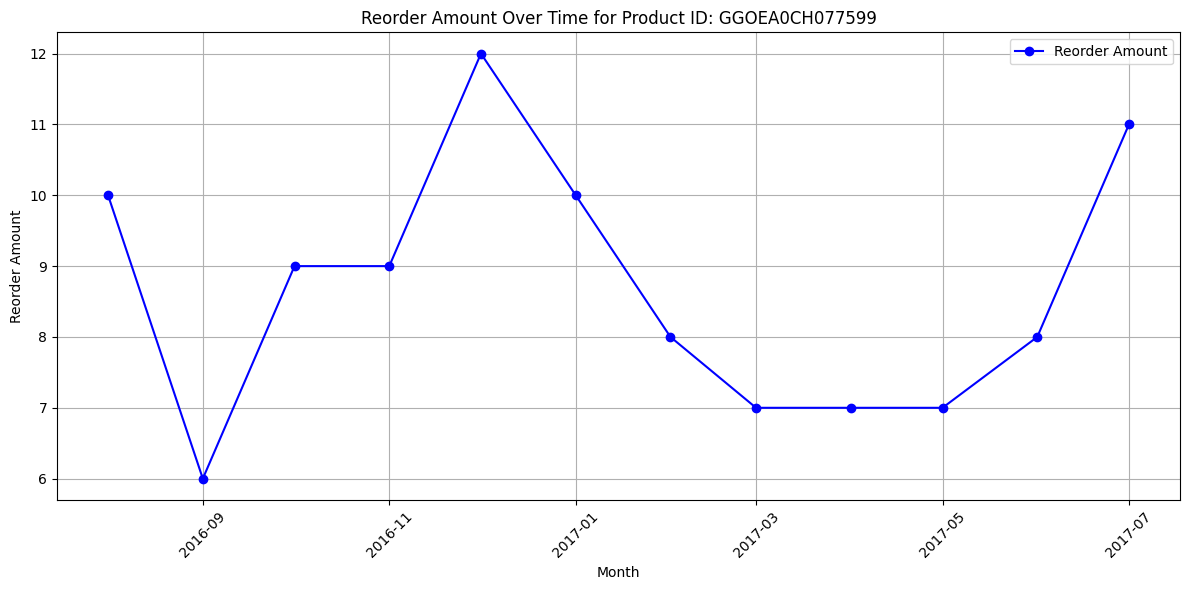

In [73]:
monthly_reorder = data.groupby([data['year_month'].dt.to_period('M'), 'product_id'])['final_reorder_amount'].sum().reset_index()
monthly_reorder['year_month'] = monthly_reorder['year_month'].dt.to_timestamp()

print(monthly_reorder.head)

sample_product_id = 'GGOEA0CH077599' # Replace with product id for viewing

sample_reorder_train = monthly_reorder[monthly_reorder['product_id'] == sample_product_id]

plt.figure(figsize=(12, 6))
plt.plot(sample_reorder_train['year_month'], sample_reorder_train['final_reorder_amount'], marker='o', color='b', label='Reorder Amount')
plt.title(f'Reorder Amount Over Time for Product ID: {sample_product_id}')
plt.xlabel('Month')
plt.ylabel('Reorder Amount')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


## Use test data for Next Month Predictions

We apply the same processing to test data.

In [71]:
test_data = pd.read_csv('forecast_predictions.csv')
test_data['year_month'] = pd.to_datetime(test_data['year_month'], format='%m/%d/%Y')

test_data['service_level'] = test_data['product_category'].map(service_level_mapping)
test_data['gross_profit_margin'] = test_data['product_category'].map(profit_margin_mapping)
test_data['demand_variability'] = test_data.groupby('product_id')['forecast_qty'].transform('std').fillna(0)
test_data['Z_score'] = test_data['service_level'].apply(lambda x: norm.ppf(x))
test_data['base_safety_stock'] = test_data['Z_score'] * test_data['demand_variability'] * np.sqrt(lead_time)
test_data['adjusted_safety_stock'] = test_data['base_safety_stock'] * (1 + test_data['gross_profit_margin'] * profit_margin_scale)
test_data['seasonal_adjustment'] = np.where(test_data['year_month'].dt.month == 12, seasonal_multiplier, 1.0)
test_data['final_safety_stock'] = test_data['adjusted_safety_stock'] * test_data['seasonal_adjustment']
test_data['reorder_amount'] = np.maximum(0, test_data['forecast_qty'] + test_data['final_safety_stock'] - test_data['forecast_qty'])
test_data['final_reorder_amount'] = np.where(
    test_data['demand_variability'] > high_variability_threshold,
    test_data['reorder_amount'] * variability_multiplier,
    test_data['reorder_amount']
)
test_data['final_reorder_amount'] = np.ceil(test_data['final_reorder_amount'])

monthly_reorder_test = test_data.groupby([test_data['year_month'].dt.to_period('M'), 'product_id'])['final_reorder_amount'].sum().reset_index()
monthly_reorder_test['year_month'] = monthly_reorder_test['year_month'].dt.to_timestamp()

print("\nNext Month's Reorder Plan:")
print(monthly_reorder_test)


Next Month's Reorder Plan:
     year_month      product_id  final_reorder_amount
0    2017-01-01  GGOEA0CH077599                   8.0
1    2017-01-01  GGOEAAAB034813                   0.0
2    2017-01-01  GGOEAAAB034814                  12.0
3    2017-01-01  GGOEAAAB034815                  12.0
4    2017-01-01  GGOEAAAB034816                   8.0
...         ...             ...                   ...
1113 2017-01-01  GGOEYOCR077399                   0.0
1114 2017-01-01  GGOEYOCR077799                 106.0
1115 2017-01-01  GGOEYOCR078099                   0.0
1116 2017-01-01  GGOEYOLR018699                 528.0
1117 2017-01-01  GGOEYOLR080599                  20.0

[1118 rows x 3 columns]
